# Face Generation

#### Submitted by: Harish Vasudevasarma (Sep 22, 2017)

In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

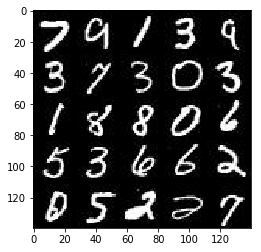

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

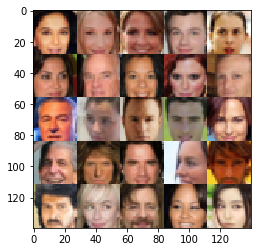

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, stddev=0.02):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #Layer 1
        L1 = tf.layers.conv2d(images, 
                               filters=32, 
                                 kernel_size=(5,5), 
                                   strides=(2,2), 
                                     padding='SAME', 
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        
        L1 = tf.maximum(alpha * L1, L1)
        
        #Layer 2
        L2 = tf.layers.conv2d(L1, 
                               filters=64, 
                                 kernel_size=(5,5), 
                                   strides=(2,2), 
                                     padding='SAME',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        L2 = tf.layers.batch_normalization(L2, training=True)
        L2 = tf.maximum(alpha * L2, L2)
        
        #Layer 3
        L3 = tf.layers.conv2d(L2, 
                                   filters=128, 
                                     kernel_size=(5,5), 
                                       strides=(2,2), 
                                         padding='SAME',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        L3 = tf.layers.batch_normalization(L3, training=True)
        L3 = tf.maximum(alpha * L3, L3)
        # Layer 3 out: 4x4x128
        
        L4 = tf.layers.conv2d(L3, 
                                   filters=256, 
                                     kernel_size=(5,5), 
                                       strides=(2,2), 
                                         padding='SAME',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        L4 = tf.layers.batch_normalization(L4, training=True)
        L4 = tf.maximum(alpha * L4, L4)
        # Layer 4 out: 2x2x256
        
        flattened = tf.reshape(L4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        L1 = tf.layers.dense(z, 4 * 4 * 512)
        L1 = tf.reshape(L1, (-1, 4, 4, 512))
        L1 = tf.layers.batch_normalization(L1, training=is_train)
        L1 = tf.maximum(alpha * L1, L1)
        
        
        L2 = tf.layers.conv2d_transpose(L1, 
                                        filters=256, kernel_size=(4,4), strides=(1,1), padding='VALID',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        L2 = tf.layers.batch_normalization(L2, training=is_train)
        L2 = tf.maximum(alpha * L2, L2)
        
        L3 = tf.layers.conv2d_transpose(L2, 
                                             filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        L3 = tf.layers.batch_normalization(L3, training=is_train)
        L3 = tf.maximum(alpha * L3, L3)
        
        L4 = tf.layers.conv2d_transpose(L3, 
                                             filters=64, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        L4 = tf.layers.batch_normalization(L4, training=is_train)
        L4 = tf.maximum(alpha * L4, L4)
        
        logits = tf.layers.conv2d_transpose(L4, 
                                            filters=out_channel_dim, kernel_size=(3,3), strides=(1,1), padding='SAME',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                                logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    
    dis_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                                logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    gen_loss = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(
                                logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, in_learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, in_learning_rate: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, in_learning_rate: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train),
                         "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5036... Generator Loss: 2.3615
Epoch 1/2... Discriminator Loss: 0.4708... Generator Loss: 4.3300
Epoch 1/2... Discriminator Loss: 0.3772... Generator Loss: 4.8676
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 2.9203
Epoch 1/2... Discriminator Loss: 0.6073... Generator Loss: 3.8487
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 3.7684
Epoch 1/2... Discriminator Loss: 0.4645... Generator Loss: 2.4133
Epoch 1/2... Discriminator Loss: 0.3521... Generator Loss: 3.9540
Epoch 1/2... Discriminator Loss: 0.8352... Generator Loss: 1.3826
Epoch 1/2... Discriminator Loss: 0.4849... Generator Loss: 3.3627


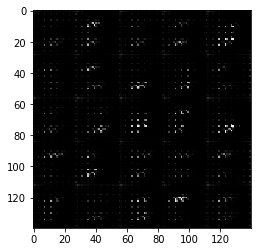

Epoch 1/2... Discriminator Loss: 0.3668... Generator Loss: 3.5694
Epoch 1/2... Discriminator Loss: 0.4750... Generator Loss: 2.3063
Epoch 1/2... Discriminator Loss: 0.4592... Generator Loss: 2.3310
Epoch 1/2... Discriminator Loss: 0.6008... Generator Loss: 1.7197
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 0.7450
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.3175
Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 1.4588
Epoch 1/2... Discriminator Loss: 0.8928... Generator Loss: 1.2879
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.9764
Epoch 1/2... Discriminator Loss: 0.9762... Generator Loss: 2.2240


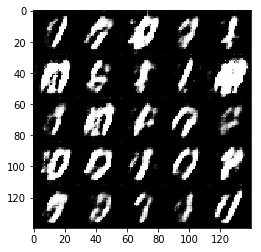

Epoch 1/2... Discriminator Loss: 0.7704... Generator Loss: 2.3483
Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 1.6605
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.1821
Epoch 1/2... Discriminator Loss: 1.6681... Generator Loss: 0.3463
Epoch 1/2... Discriminator Loss: 0.8218... Generator Loss: 1.4791
Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 1.1896
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.4075
Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 0.8533
Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 1.0097
Epoch 1/2... Discriminator Loss: 1.0990... Generator Loss: 0.8952


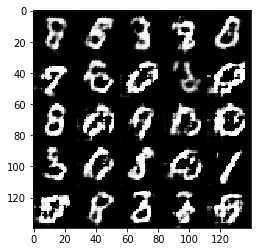

Epoch 1/2... Discriminator Loss: 1.0851... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 0.9423
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.8088
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 0.6360
Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 0.8587
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 1.3024
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.4948
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.6290
Epoch 1/2... Discriminator Loss: 1.8266... Generator Loss: 0.2907


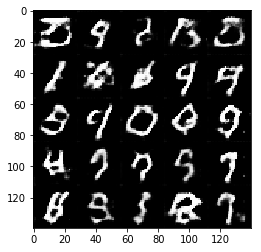

Epoch 1/2... Discriminator Loss: 1.1705... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.2760... Generator Loss: 0.5878
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 1.4038... Generator Loss: 0.5630
Epoch 1/2... Discriminator Loss: 1.0350... Generator Loss: 0.9036
Epoch 1/2... Discriminator Loss: 1.5869... Generator Loss: 0.3980
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 1.1474
Epoch 1/2... Discriminator Loss: 1.7553... Generator Loss: 1.2288
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.7851
Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 0.7100


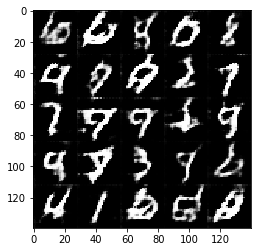

Epoch 1/2... Discriminator Loss: 0.9889... Generator Loss: 0.9413
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 0.6213
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 1.7534
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.5216
Epoch 1/2... Discriminator Loss: 1.0597... Generator Loss: 0.7765
Epoch 1/2... Discriminator Loss: 1.2982... Generator Loss: 1.0246
Epoch 1/2... Discriminator Loss: 1.9784... Generator Loss: 0.3570
Epoch 1/2... Discriminator Loss: 1.6084... Generator Loss: 2.7659


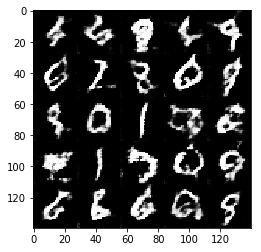

Epoch 1/2... Discriminator Loss: 1.0779... Generator Loss: 1.1185
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.7864
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 1.1955... Generator Loss: 0.9256
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 0.4520
Epoch 1/2... Discriminator Loss: 0.7864... Generator Loss: 1.3791
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 0.8844
Epoch 1/2... Discriminator Loss: 0.9622... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.5972


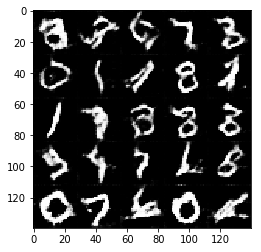

Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 1.3601
Epoch 1/2... Discriminator Loss: 1.2961... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 0.9580... Generator Loss: 1.0592
Epoch 1/2... Discriminator Loss: 1.2080... Generator Loss: 0.6360
Epoch 1/2... Discriminator Loss: 0.8919... Generator Loss: 2.0458
Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 2.2215
Epoch 1/2... Discriminator Loss: 1.0424... Generator Loss: 1.1532
Epoch 1/2... Discriminator Loss: 0.7579... Generator Loss: 1.5115
Epoch 1/2... Discriminator Loss: 1.5686... Generator Loss: 0.6044
Epoch 1/2... Discriminator Loss: 1.3039... Generator Loss: 0.6481


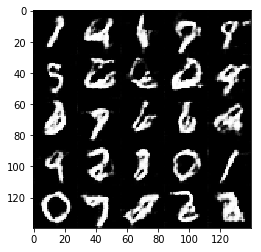

Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 1.2052
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 1.1945
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.5185
Epoch 1/2... Discriminator Loss: 1.5041... Generator Loss: 0.4462
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.9017
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 2.1440... Generator Loss: 0.2155
Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 1.4492
Epoch 1/2... Discriminator Loss: 1.5980... Generator Loss: 0.4237
Epoch 1/2... Discriminator Loss: 1.4474... Generator Loss: 0.8071


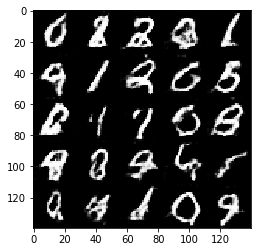

Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 2.1326... Generator Loss: 0.2598
Epoch 1/2... Discriminator Loss: 1.6734... Generator Loss: 0.3549
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 1.1633
Epoch 2/2... Discriminator Loss: 2.4634... Generator Loss: 0.1672
Epoch 2/2... Discriminator Loss: 1.1905... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 1.0665... Generator Loss: 1.2104
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 1.4768... Generator Loss: 0.4237
Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 0.6234


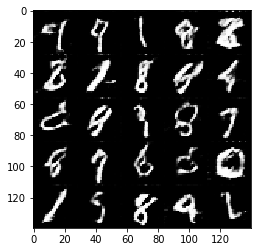

Epoch 2/2... Discriminator Loss: 2.0552... Generator Loss: 0.2382
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.7763
Epoch 2/2... Discriminator Loss: 0.7960... Generator Loss: 1.1934
Epoch 2/2... Discriminator Loss: 1.2494... Generator Loss: 0.6122
Epoch 2/2... Discriminator Loss: 1.7241... Generator Loss: 0.4376
Epoch 2/2... Discriminator Loss: 1.8655... Generator Loss: 0.2839
Epoch 2/2... Discriminator Loss: 1.5399... Generator Loss: 0.4210
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.6298
Epoch 2/2... Discriminator Loss: 1.3245... Generator Loss: 0.5590
Epoch 2/2... Discriminator Loss: 1.2548... Generator Loss: 0.9893


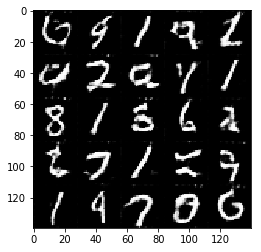

Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 1.2395
Epoch 2/2... Discriminator Loss: 1.4281... Generator Loss: 0.4811
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 1.9197... Generator Loss: 0.2712
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 2.0211... Generator Loss: 0.2260
Epoch 2/2... Discriminator Loss: 1.5527... Generator Loss: 0.4093
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 2.0783
Epoch 2/2... Discriminator Loss: 1.7692... Generator Loss: 0.3128
Epoch 2/2... Discriminator Loss: 1.1232... Generator Loss: 1.1725


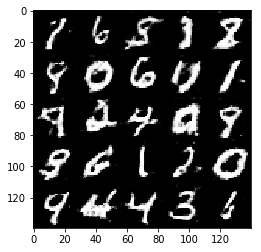

Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 1.2649
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 0.9817
Epoch 2/2... Discriminator Loss: 1.6938... Generator Loss: 0.3620
Epoch 2/2... Discriminator Loss: 1.1106... Generator Loss: 1.1143
Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 0.4984
Epoch 2/2... Discriminator Loss: 0.9883... Generator Loss: 1.7597
Epoch 2/2... Discriminator Loss: 1.7158... Generator Loss: 0.3423
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 0.9015
Epoch 2/2... Discriminator Loss: 0.8944... Generator Loss: 1.0929
Epoch 2/2... Discriminator Loss: 1.1012... Generator Loss: 0.7364


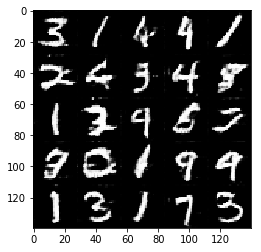

Epoch 2/2... Discriminator Loss: 1.9951... Generator Loss: 0.2780
Epoch 2/2... Discriminator Loss: 1.0843... Generator Loss: 0.7952
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 1.2139
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 1.7607
Epoch 2/2... Discriminator Loss: 1.4657... Generator Loss: 0.4563
Epoch 2/2... Discriminator Loss: 2.2239... Generator Loss: 0.2023
Epoch 2/2... Discriminator Loss: 1.5282... Generator Loss: 0.4294
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.7864
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 1.1388
Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.7738


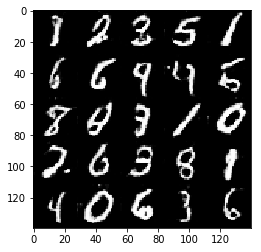

Epoch 2/2... Discriminator Loss: 1.9082... Generator Loss: 0.2691
Epoch 2/2... Discriminator Loss: 1.3282... Generator Loss: 0.5666
Epoch 2/2... Discriminator Loss: 0.8832... Generator Loss: 1.0272
Epoch 2/2... Discriminator Loss: 1.2907... Generator Loss: 0.5626
Epoch 2/2... Discriminator Loss: 1.1715... Generator Loss: 0.6525
Epoch 2/2... Discriminator Loss: 1.9246... Generator Loss: 0.2785
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.6572
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 0.9521
Epoch 2/2... Discriminator Loss: 1.5508... Generator Loss: 0.5092
Epoch 2/2... Discriminator Loss: 1.1187... Generator Loss: 0.7865


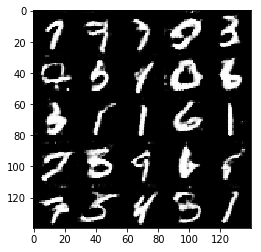

Epoch 2/2... Discriminator Loss: 2.4339... Generator Loss: 0.1546
Epoch 2/2... Discriminator Loss: 1.4935... Generator Loss: 0.4567
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 0.9744
Epoch 2/2... Discriminator Loss: 1.0816... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 0.9977
Epoch 2/2... Discriminator Loss: 1.0682... Generator Loss: 0.7684
Epoch 2/2... Discriminator Loss: 2.1257... Generator Loss: 0.2210
Epoch 2/2... Discriminator Loss: 1.1394... Generator Loss: 1.6167
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.9154
Epoch 2/2... Discriminator Loss: 1.4486... Generator Loss: 2.7277


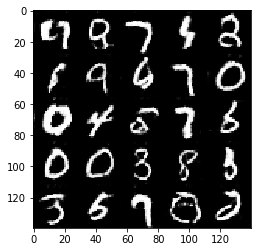

Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.5261... Generator Loss: 1.7799
Epoch 2/2... Discriminator Loss: 0.9992... Generator Loss: 1.1131
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 0.6277
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 0.5635
Epoch 2/2... Discriminator Loss: 1.0905... Generator Loss: 1.4708
Epoch 2/2... Discriminator Loss: 1.8155... Generator Loss: 2.5150
Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 1.1251
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 1.7044... Generator Loss: 0.3380


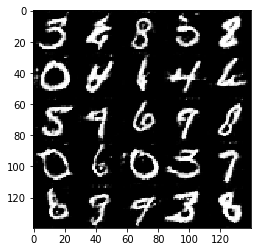

Epoch 2/2... Discriminator Loss: 2.0589... Generator Loss: 0.2484
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 1.5852... Generator Loss: 0.4091
Epoch 2/2... Discriminator Loss: 1.5651... Generator Loss: 0.4066
Epoch 2/2... Discriminator Loss: 1.2601... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 1.8346... Generator Loss: 0.3135
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 1.6244
Epoch 2/2... Discriminator Loss: 1.0282... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 1.0249... Generator Loss: 1.1470
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 0.6343


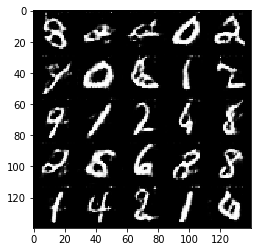

Epoch 2/2... Discriminator Loss: 1.0494... Generator Loss: 0.7559
Epoch 2/2... Discriminator Loss: 2.2049... Generator Loss: 0.1877
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.7882
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.5869
Epoch 2/2... Discriminator Loss: 0.9523... Generator Loss: 1.8822
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 1.2582


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.3064
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.4873
Epoch 1/1... Discriminator Loss: 0.6729... Generator Loss: 1.4749
Epoch 1/1... Discriminator Loss: 0.6392... Generator Loss: 1.7578
Epoch 1/1... Discriminator Loss: 0.5435... Generator Loss: 2.0055
Epoch 1/1... Discriminator Loss: 0.5665... Generator Loss: 1.9245
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 2.1045


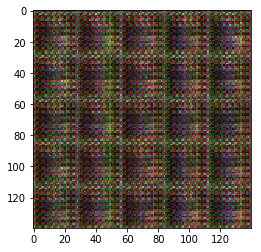

Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 2.4719
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.5405
Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 2.7496
Epoch 1/1... Discriminator Loss: 0.7698... Generator Loss: 1.4016
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.5760
Epoch 1/1... Discriminator Loss: 0.7392... Generator Loss: 2.1745
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 2.2195
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.3736
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 1.7986


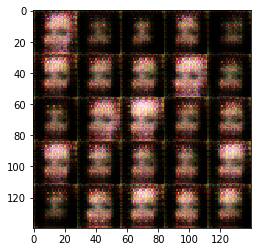

Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.3455
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.4964
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 2.2029
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 2.4075
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 1.4595
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 1.9107
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.7444


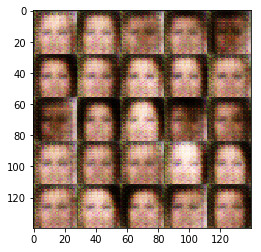

Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 2.0128
Epoch 1/1... Discriminator Loss: 0.7977... Generator Loss: 2.2433
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 2.0297
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 1.0787
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.8761
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 1.4496
Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 1.8668
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 2.5245


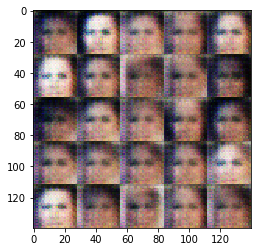

Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.4204
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.4972
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.4079
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.2712


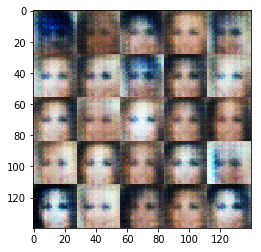

Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.3599
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.3280
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.8948


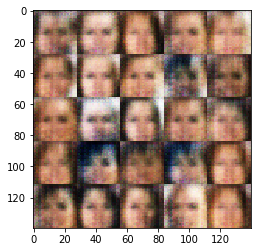

Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.1975
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.3287
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.3806
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.3725


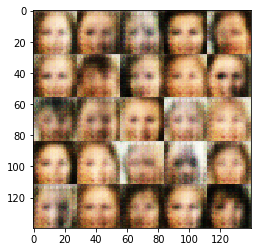

Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.2786
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.1545
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.0793


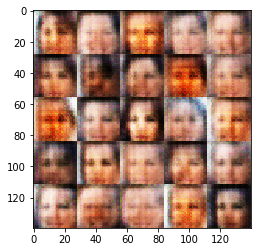

Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.5437
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.1139
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 1.4681
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.1659


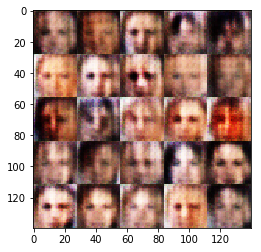

Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 1.2655
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.0983


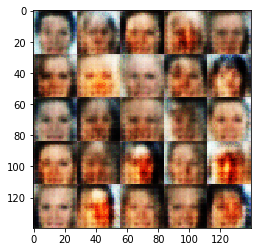

Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.9220


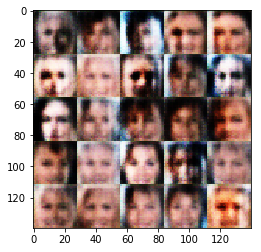

Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.3123
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.3067
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 0.8880... Generator Loss: 1.4473
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.2892
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.8682


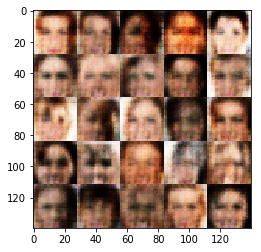

Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.1542
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 1.9459
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.4026
Epoch 1/1... Discriminator Loss: 0.8276... Generator Loss: 1.6727


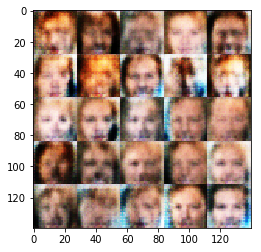

Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.3757
Epoch 1/1... Discriminator Loss: 1.7827... Generator Loss: 0.3209
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 1.2603
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 0.7544... Generator Loss: 1.6130
Epoch 1/1... Discriminator Loss: 0.8494... Generator Loss: 1.6285
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 2.4779


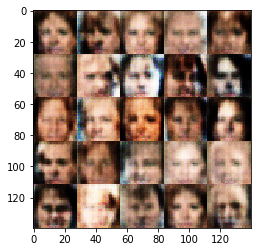

Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.2231
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 2.2534
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.5953
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.0432


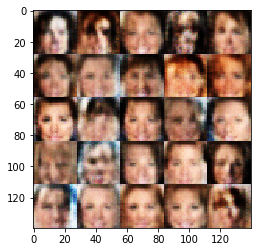

Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.9892
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 2.2346
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 2.0782
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 1.8695
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.2768


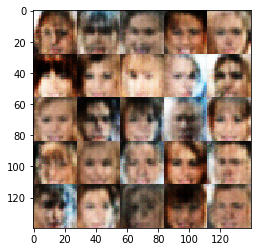

Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 1.1194... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.7858
Epoch 1/1... Discriminator Loss: 1.7497... Generator Loss: 0.3211
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 2.1302
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.7958


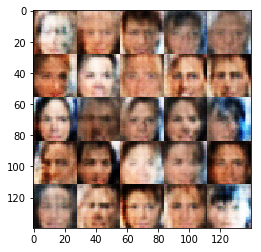

Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 1.0400
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 3.2554
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.5205
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 1.1514
Epoch 1/1... Discriminator Loss: 1.6698... Generator Loss: 0.3399
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 1.7682


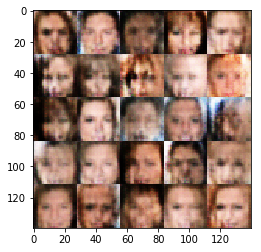

Epoch 1/1... Discriminator Loss: 1.6799... Generator Loss: 0.3465
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 0.6445... Generator Loss: 1.7596
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 2.8108
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.5732


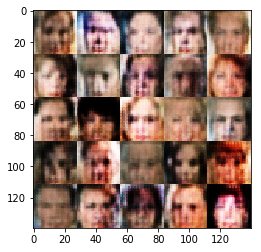

Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.3712
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.1459
Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.7992
Epoch 1/1... Discriminator Loss: 0.9918... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 2.4751... Generator Loss: 0.1542
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.7417


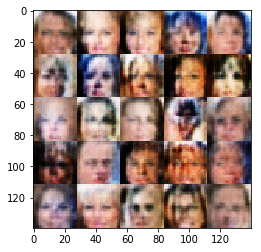

Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.0511


In [ ]:
batch_size = 128
z_dim = 108
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.